<a href="https://colab.research.google.com/github/essat20/NLP_CW_210021102/blob/main/NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# downloading datasets
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 27.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


# Import Statements

In [2]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
from datasets import load_dataset # to load dataset
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Setting up and Preprocessing

In [3]:
#Load the emotion dataset
dataset = load_dataset('emotion', trust_remote_code=True) # have to use the second parameter as there is required custom code for the dataset to be loaded properly

# extract text sequences and labels
texts = dataset['train']['text']
labels = dataset['train']['label']

# Tokenize the text using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(texts, truncation=True, padding=True) # tokenise the data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

#Definition of PyTorch Dataset for Emotion Classification

In [4]:
# Define a PyTorch Dataset
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#Data Preparation and Splitting

In [5]:
# Ensure that the number of samples in encodings and labels matches
assert len(encodings['input_ids']) == len(labels), "Number of samples in encodings and labels doesn't match"

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

In [6]:
# Define the model architecture
class EmotionClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.2) # added a dropout layer
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    #forward propagate function
    def forward(self, input_ids, attention_mask): # used to calculate the predicted outputs and loss
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Setting up for Training

In [7]:
# Instantiate the model
num_labels = len(dataset['train'].features['label'].names)
model = EmotionClassifier(num_labels)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training the Model

In [8]:
all_train_losses = [] # these arrays will be used to create the loss epoch graphs
all_val_losses = []
epoch_num = 5

# training the model
for epoch in range(epoch_num):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad() # clear the gradients

        # forward pass
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        #calculate gradients and update weights
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    all_train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}/{epoch_num}, Train Loss: {avg_train_loss:.4f}')

    model.eval()
    val_loss = 0 # initialising the variable
    correct_preds = 0 # initialising the variable
    total_preds = 0 # initialising the variable


    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()


            # calculate correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    all_val_losses.append(avg_val_loss)
    val_accuracy = correct_preds / total_preds

    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print("all train losses:") # prints the accumilated training losses
print(all_train_losses)
print("all val losses:")
print(all_val_losses) # prints the accumilated validatyion losses

Epoch 1/5, Train Loss: 0.4190
Validation Loss: 0.1557, Validation Accuracy: 0.9291
Epoch 2/5, Train Loss: 0.1373
Validation Loss: 0.1665, Validation Accuracy: 0.9278
Epoch 3/5, Train Loss: 0.1004
Validation Loss: 0.1597, Validation Accuracy: 0.9297
Epoch 4/5, Train Loss: 0.0805
Validation Loss: 0.1563, Validation Accuracy: 0.9350
Epoch 5/5, Train Loss: 0.0749
Validation Loss: 0.2045, Validation Accuracy: 0.9300
all train losses:
[0.4189731795154512, 0.1373134430241771, 0.10036781363713089, 0.0805250759513001, 0.07489602485060459]
all val losses:
[0.15573387489188462, 0.1665452571748756, 0.15970178940799087, 0.1563302000821568, 0.20447794321458787]


# Plotting loss/epoch

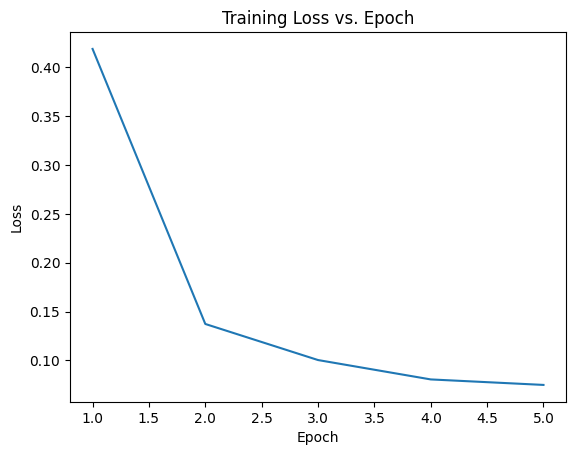

In [9]:
 #plot loss/epoch graph
plt.plot(range(1, epoch_num+1), all_train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.show()